### Contents
1. Extract images based on csv file's ID
2. Prepare data for building CNN models for image data
3. Build simple CNN model
4. Summary

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
import sys
sys.path.append("/Users/Zhongyu/Documents/projects/CNNplayground/leaf/code")
sys.path.append("/Users/Zhongyu/Documents/projects/CNNplayground/")
from utils import unpickle_data, one_hot_encode
from preprocess import center_data, zca_whiten, pca_whiten
from cnn import *
from sklearn.model_selection import train_test_split
#from preparation_pipes import CNN_pipe_img

/Users/Zhongyu/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Extract ID, species, images from train.csv and images_downsized

In [2]:
data = pd.read_csv("../train.csv")

In [3]:
ID_species = data[['id','species']]

In [40]:
species_encode = unpickle_data("../species_encode")
ID_images = unpickle_data("../images_downsized32")

In [41]:
ID_species_encode = ID_species.replace({'species':species_encode})

In [42]:
ID_species_encode['images'] = ID_species['id'].map(lambda ID: ID_images[ID])
print ID_species_encode.shape

(990, 3)


In [43]:
ID_species_encode.head()

,id,species,images
0,1,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,..."
1,2,49,"[[0, 0, 1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,65,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,5,94,"[[0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 3, 0, 0, 0, 0,..."
4,6,84,"[[0, 0, 0, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 0, 0,..."


**Verify**

In [44]:
sample0 = ID_species_encode['images'].iloc[0]

In [45]:
print type(sample0)
print sample0.shape

<type 'numpy.ndarray'>
(32, 32)


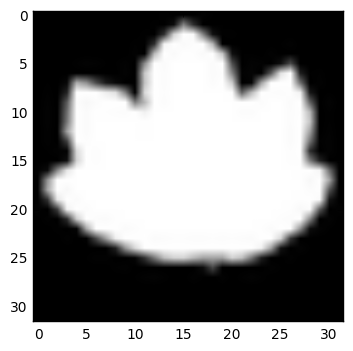

In [46]:
plt.imshow(sample0,cmap=plt.cm.gray)

In [47]:
X = np.stack([ID_images[ID] for ID in ID_species['id']], axis=0)
#X = ID_species_encode['images']
y = ID_species_encode['species']

### Prepare data for CNN models
 - split into training and testing/validation set
 - one hot encode y
 - preprocess X: center, whiten, lower percision

In [48]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=110, stratify=y, random_state=916)

In [49]:
train_y = one_hot_encode(train_y)
test_y = one_hot_encode(test_y)
print train_y.shape
print train_y.dtype

(880, 99)
float32


In [50]:
def center_whiten(X):
    X2D = X.reshape((X.shape[0],-1))
    import time
    t = time.time()
    X_centered = center_data(X2D)
    X_whiten = zca_whiten(X_centered) # whitening costs a while
    tcost = time.time() - t
    print tcost
    X_cw = X_centered.reshape(X.shape)
    return X_cw

In [51]:
train_X_cw = center_whiten(train_X)

0.735202074051


In [52]:
test_X_cw = center_whiten(test_X)

0.596307039261


In [53]:
train_X_cw, test_X_cw = train_X_cw[:,:,:,None].astype(np.float32), test_X_cw[:,:,:,None].astype(np.float32)

In [54]:
print train_X_cw.shape
print train_X_cw.dtype

(880, 32, 32, 1)
float32


### Build CNN models

In [68]:
learning_rate = 0.0005

In [71]:
batch_size = 64
input_shape = [batch_size, train_X_cw.shape[1], train_X_cw.shape[2], train_X_cw.shape[3]]
num_class = train_y.shape[1]
model = cnn_graph(input_shape, num_class)
model.setup_data(batch_size, valid_X=test_X_cw, valid_y=test_y)
conv_wt_initializer = tf.truncated_normal_initializer(stddev=0.10)#tf.contrib.layers.xavier_initializer_conv2d() 
conv_depth = 4

conv_layers = [('conv1', 5), ('conv2', 5)]
#conv_layers = [('conv1', 5)]
for conv_layer in conv_layers:
    layer_name, filter_size = conv_layer[0], conv_layer[1]
    model.add_conv2d_layer(layer_name, filter_size, conv_depth,conv_wt_initializer, add_output_summary=False)
    model.add_batchnorm_layer(layer_name+'/batchnorm', decay=.9, add_output_summary=False)
    model.add_act_layer(layer_name+'/activation')
    model.add_pool_layer(layer_name+'/pool')
    conv_depth *= 2
    
# Fully Connected layer
fc_layers = [('fc1', 256), ('fc2', num_class)]
fc_wt_initializer = tf.contrib.layers.variance_scaling_initializer()
for fc_layer in fc_layers:
    layer_name, num_neuron = fc_layer[0], fc_layer[1]
    model.add_fc_layer(layer_name, num_neuron, fc_wt_initializer, add_output_summary=False)
    model.add_batchnorm_layer(layer_name+'/batchnorm', decay=.9, add_output_summary=False)
    model.add_act_layer(layer_name+'/activation')
    if layer_name!=fc_layers[-1][0]:
        model.add_dropout_layer(layer_name+'/dropout')

model.setup_learning_rate(learning_rate, exp_decay=False, add_output_summary=False)
train_loss = model.compute_train_loss(add_output_summary=False)
valid_loss = model.compute_valid_loss(add_output_summary=False)
optimizer = model.setup_optimizer(tf.train.AdamOptimizer, add_output_summary=False)

In [72]:
epoches = 10000
dropout = 0.5
tloss_lst = list()
vloss_lst = list()
with tf.Session(graph=model.get_graph()) as sess:
    tf.initialize_all_variables().run()
    print("Initialized")
    model.set_kp_value('fc1/dropout', dropout)
    train_feed_dict = model.get_kp_collection_dict()
    for step in range(epoches):
        offset = (step*batch_size)%(train_X_cw.shape[0]-batch_size)
        batch_X = train_X_cw[offset:(offset+batch_size), :, :, :]
        batch_y = train_y[offset:(offset+batch_size), :]
        train_feed_dict.update({model.train_X : batch_X, model.train_y : batch_y})
        _, tloss = sess.run([optimizer, train_loss], feed_dict=train_feed_dict)
        tloss_lst.append(tloss)
        vloss = sess.run(valid_loss, feed_dict=dict(model.kp_reference_feed_dict))
        vloss_lst.append(vloss)
        if step%500 == 0:
            print('Epoch: %d:\tTrain Loss: %.6f\tValid Loss: %.6f' %(step, tloss, vloss))
    print("Finished training")
    vloss = sess.run(valid_loss, feed_dict=dict(model.kp_reference_feed_dict))#valid_feed_dict
    print("Final valid loss: %.6f" %(vloss))

Initialized
Epoch: 0:	Train Loss: 4.878596	Valid Loss: 9.138610
Epoch: 500:	Train Loss: 1.281697	Valid Loss: 1.767373
Epoch: 1000:	Train Loss: 0.723766	Valid Loss: 1.501439
Epoch: 1500:	Train Loss: 0.466237	Valid Loss: 1.397314
Epoch: 2000:	Train Loss: 0.305719	Valid Loss: 1.348783
Epoch: 2500:	Train Loss: 0.204622	Valid Loss: 1.316814
Epoch: 3000:	Train Loss: 0.157638	Valid Loss: 1.325191
Epoch: 3500:	Train Loss: 0.118820	Valid Loss: 1.274694
Epoch: 4000:	Train Loss: 0.108958	Valid Loss: 1.286941
Epoch: 4500:	Train Loss: 0.104514	Valid Loss: 1.296308
Epoch: 5000:	Train Loss: 0.073272	Valid Loss: 1.241783
Epoch: 5500:	Train Loss: 0.090418	Valid Loss: 1.270299
Epoch: 6000:	Train Loss: 0.059901	Valid Loss: 1.267620
Epoch: 6500:	Train Loss: 0.072256	Valid Loss: 1.260132
Epoch: 7000:	Train Loss: 0.024028	Valid Loss: 1.317691
Epoch: 7500:	Train Loss: 0.026659	Valid Loss: 1.263311
Epoch: 8000:	Train Loss: 0.033043	Valid Loss: 1.271834
Epoch: 8500:	Train Loss: 0.032620	Valid Loss: 1.260111
Ep

**training and validation loss visulization**

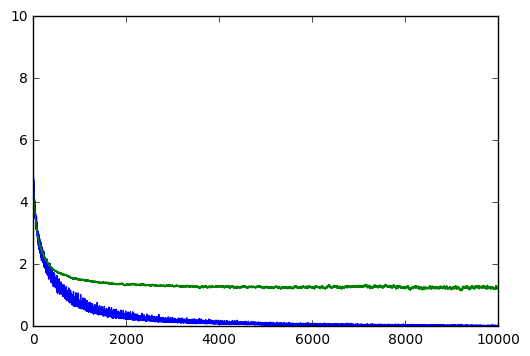

In [73]:
plt.plot(range(len(tloss_lst)), tloss_lst)
plt.hold('on')
plt.plot(range(len(vloss_lst)), vloss_lst)
plt.show()